# Dataset Processing

## Introduction

TODO

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageSequence
import ipywidgets as widgets
from util import TLDataset, readSetFromFile, writeSetToFile

import os
import os.path
import glob

In [13]:
# def convertTIFtoPNG(file, folder):
#     filename_ext = os.path.basename(file)
#     filename = os.path.splitext(filename_ext)[0]
    
#     im = None
#     try:
#         im = Image.open(file)
#     except:
#         print(f"Failed to open file with path '{file}'!")

#     for i, page in enumerate(ImageSequence.Iterator(im)):
#         path = folder + filename + ".png"
#         try:
#             page.save(path)
#         except:
#             print(f"Failed to save file to path '{path}'!")

In [2]:
def convertTIFtoPNG(folder):
    files = glob.glob(folder + "*.tif")
    print(f"Found {len(files)} *.tif files to convert in '{folder}' directory.")

    for file in files:
        filename_ext = os.path.basename(file)
        filename = os.path.splitext(filename_ext)[0]
        
        im = None
        try:
            im = Image.open(file)
        except:
            print(f"Failed to open file with path '{file}'!")

        for i, page in enumerate(ImageSequence.Iterator(im)):
            path = folder + filename + ".png"
            try:
                page.save(path)
            except:
                print(f"Failed to save file to path '{path}'!")

# convertTIFtoPNG("../learning/imagery/")
# convertTIFtoPNG("../learning/masks/")

The masks contain several classifications, including 0 for forest cover, 2 for river bank, and 1 for river pixels. We need to convert these to binary masks where 0 are non-river pixels and 1 are river pixels.

In [ ]:
def processMasks(folder):
    files = glob.glob(folder + "*.png")

    for file in files:
        filename_ext = os.path.basename(file)
        filename = os.path.splitext(filename_ext)[0]

        if "corrected" in filename or "manual" in filename:
            continue

        # Open the image using Pillow and convert to a numpy array
        original_image = np.array(Image.open(file))

        # Create a new array with 1 where the original array is 1, and 0 elsewhere
        corrected_mask = np.where(original_image == 1, 1, 0)
        output_image = Image.fromarray(corrected_mask.astype(np.uint8))

        # Save the output image in the output folder
        path = folder + filename + "_corrected.png"
        try:
            output_image.save(path)
        except:
            print("Failed to save " + path)

# processMasks("../learning/masks/")

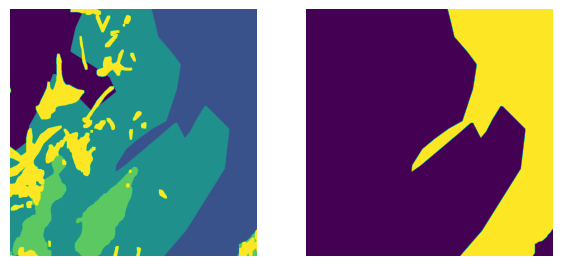

In [27]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,7))

target = "../learning/masks/Elwha_LR_20120407_014_006"
original_mask = plt.imread(target + ".png")
corrected_mask = plt.imread(target + "_corrected.png")

axes[0].imshow(original_mask)
axes[0].axis("off")
axes[1].imshow(corrected_mask)
axes[1].axis("off")

plt.show()

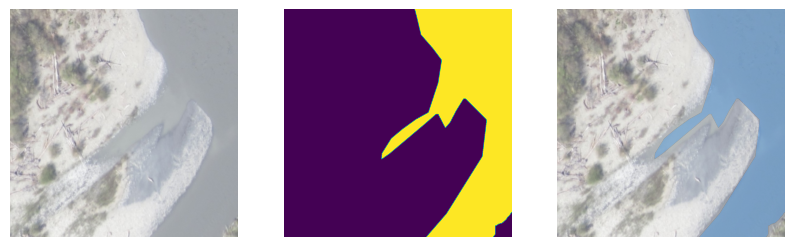

In [32]:
def showMask(mask, ax, random_color=False):
    color = np.array([30/255, 144/255, 255/255, 0.3])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def compareOriginalMaskAndOverlay(target: str):
    image = Image.open(f"../learning/imagery/{target}.png")
    mask = Image.open(f"../learning/masks/{target}_corrected.png")

    figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))

    original_image = np.array(image)
    axes[0].imshow(original_image)
    axes[0].axis("off")

    ground_truth_seg = np.array(mask)
    axes[1].imshow(ground_truth_seg)
    axes[1].axis("off")

    axes[2].imshow(original_image)
    showMask(ground_truth_seg, axes[2])
    axes[2].axis("off")

    plt.show()

compareOriginalMaskAndOverlay("Elwha_LR_20120407_014_006")

When manually correcting masks, we don't want this to get overwritten by the mask processing code earlier in the notebook, so we will save them with a custom name. We also will have a hard time editing a binary image file with any of the free image software applications on the market, so we will instead save them as grayscale images. Then, we can use this code to convert them to the proper format.

In [2]:
def convertManualMask(file) -> bool:
    filename_ext = os.path.basename(file)
    filename = os.path.splitext(filename_ext)[0]

    if not "manual" in filename:
        return False

    # Open the image using Pillow and convert to a numpy array
    original_image = np.array(Image.open(file))
    
    # assert len(original_image.shape) == 2
    if len(original_image.shape) != 2:
        original_image = original_image[:,:,0]

    # Create a new array with 1 where the original array is non-zero, and 0 elsewhere
    corrected_mask = np.where(original_image != 0, 1, 0)
    output_image = Image.fromarray(corrected_mask.astype(np.uint8))

    # Save the output image in the output folder
    path = file.replace("_manual.png", "_corrected.png")
    try:
        output_image.save(path)
        return True
    except:
        print("Failed to save " + path)
        return False

def convertManualMasks(folder):
    files = glob.glob(folder + "*.png")
    count = 0

    for file in files:
        success = convertManualMask(file)
        if success: count += 1

    print(f"Successfully converted {count} manually corrected masks.")

In [3]:
def createManuallyEditableCopy(mask_file: str, force = False):
    # Open the image using Pillow and convert to a numpy array
    original_image = np.array(Image.open(mask_file))
    assert len(original_image.shape) == 2
    # If assertion fails:
    # original_image = original_image[:, :, 0]

    # Create a new array with 1 where the original array is non-zero, and 0 elsewhere
    corrected_mask = np.where(original_image != 0, 255, 0)
    output_image = Image.fromarray(corrected_mask.astype(np.uint8))

    # Save the output image in the output folder
    path = mask_file.replace("_corrected.png", "_manual.png")
    if os.path.exists(path) and not force:
        print("Manually segmented mask file already exists, cannot overwrite!")
        return
    
    try:
        output_image.save(path)
        print("Successfully generated manual mask starting point at:", path)
    except:
        print("Failed to save:", path)

In [4]:
images = TLDataset(
    "../learning/", "imagery/", "masks/", "*_corrected.png", 
    seed=1, subset="Train", fraction=0
)

# useful_images = set()
useful_images = readSetFromFile("../data/useful_images.txt")
print("Found and loaded list of", len(useful_images), "images marked as useful")

Found and loaded 4382 images with glob *_corrected.png.
Subset of 4382 ground truth segmentation masks marked for Train.
Found and loaded list of 220 images marked as useful


## Dataset

The first step is to build our ground truth dataset. It seems that the original processing done in 2012 included some preliminary river masks. Unfortunately, these masks are fairly poor. They also do not help with the construction of our ground truth dataset; it is easier to just manually create new masks than it is to patch up the existing masks.

The process of creating ground truth masks involves opening the original RGB image in paint.net, and drawing in white the outline of the water pixels. Then, with the fill tool the river pixels can be filled in, and this layer can be stacked onto an all black layer to create a binary mask. 

TODO: mention conversion.

In [5]:
datapoint_slider = widgets.IntSlider(
    value=0, min=0, max=len(images) - 1, step=1,
    description="Datapoint:"
)
prev_button = widgets.Button(
    description="Prev",
    tooltip="Prev",
    disabled=True,
    button_style="",
    icon="arrow-left"
)
next_button = widgets.Button(
    description="Next",
    tooltip="Next",
    disabled=False,
    button_style="",
    icon="arrow-right"
)

def changeSliderValue(diff):
    next_value = datapoint_slider.value + diff
    if next_value >= datapoint_slider.min and next_value <= datapoint_slider.max:
        datapoint_slider.value = next_value

def incrementSliderValue(_ignore): changeSliderValue(1)
def decrementSliderValue(_ignore): changeSliderValue(-1)

prev_button.on_click(decrementSliderValue)
next_button.on_click(incrementSliderValue)

next_included_button = widgets.Button(
    description="Next Included",
    tooltip="Next Included",
    disabled=False,
    button_style="",
    icon="arrow-right"
)

def incrementSliderUntilIncluded(_ignore):
    for image_index in sorted(useful_images):
        if image_index > datapoint_slider.value:
            datapoint_slider.value = image_index
            return

next_included_button.on_click(incrementSliderUntilIncluded)

def observeSliderChangeUpdateButtons():
    prev_button.disabled = datapoint_slider.value <= datapoint_slider.min
    next_button.disabled = datapoint_slider.value >= datapoint_slider.max

    valid_next_found = False
    for image_index in useful_images:
        if image_index > datapoint_slider.value:
            valid_next_found = True
            break

    next_included_button.disabled = not valid_next_found

toggle_mask_button = widgets.ToggleButton(
    value=True,
    description="Hide Mask",
    disabled=False,
)

prev_trigger_value: bool = False
toggle_include_button = widgets.ToggleButton(
    value=False,
    description="Include Datapoint",
    disabled=False,
)

def setToggle(container: set, item):
    if item in container: container.remove(item)
    else: container.add(item)

def displayMask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def overlayMask(datapoint_index: int, show_mask: bool, trigger_include_datapoint: bool):
    global prev_trigger_value
    toggle_mask_button.description = "Hide Mask" if show_mask else "Show Mask"
    
    fig, axes = plt.subplots()
    datapoint = images[datapoint_index] # type: ignore

    if trigger_include_datapoint != prev_trigger_value:
       setToggle(useful_images, datapoint_index)
       prev_trigger_value = trigger_include_datapoint

    included = datapoint_index in useful_images
    toggle_include_button.description = "Exclude Datapoint" if included else "Include Datapoint"

    print(datapoint["name"].replace(".png", ""), "(included)" if included else "")
    print("Dataset Size:", len(useful_images))

    axes.imshow(datapoint["image"])
    if show_mask: displayMask(datapoint["mask"], axes)
    axes.axis("off")

    observeSliderChangeUpdateButtons()

stepper_buttons = widgets.HBox([prev_button, next_button, next_included_button])
interactive_plot = widgets.interactive(
   overlayMask,
   datapoint_index=datapoint_slider,
   show_mask=toggle_mask_button,
   trigger_include_datapoint=toggle_include_button,
)
display(stepper_buttons, interactive_plot)

interactive(children=(IntSlider(value=0, description='Datapoint:', max=4381), ToggleButton(value=True, descrip…

TODO: Find examples of river portions which are the same spot but under different conditions.

Possible examples for Medium: #369 (Elwha_MR_20160930_029_016)

\#288 (Elwha_MR_20160930_037_011) has a ton of tiny pebbles (very hard to segment), will ensure the model learns complex river boundaries

\#673 (Elwha_MR_20160714_102_008) lots of boulders and waves, daylight picture

\#776 (Elwha_MR_20170922_062_014) some boulders and waves, many branches, medium difficulty

In [7]:
convertManualMasks("../learning/masks/")

Successfully converted 205 manually corrected masks.


In [25]:
target_mask = "../learning/masks/" + "Elwha_MR_20120810_063_013"

createManuallyEditableCopy(target_mask + "_corrected.png")
input("Press Enter once the manual copy has been edited and saved...")
convertManualMask(target_mask + "_manual.png")

Successfully generated manual mask starting point at: ../learning/masks/Elwha_MR_20120810_063_013_manual.png


True

Manually reclassified through 455

Manually classified as useful or garbage through 755 

In [27]:
print(f"Selected {len(useful_images)} images:", [images[index]["name"] for index in useful_images])

Selected 220 images: ['Elwha_LR_20170922_040_010.png', 'Elwha_MR_20160714_049_011.png', 'Elwha_LR_20150923_016_003.png', 'Elwha_LR_20160714_038_011.png', 'Elwha_MR_20160714_031_013.png', 'Elwha_MR_20150303_036_013.png', 'Elwha_MR_20160111_016_023.png', 'Elwha_MR_20130919_011_023.png', 'Elwha_MR_20140201_081_012.png', 'Elwha_MR_20160930_076_007.png', 'Elwha_LR_20160930_078_020.png', 'Elwha_LR_20130919_036_019.png', 'Elwha_LR_20150923_093_012.png', 'Elwha_LR_20160930_096_013.png', 'Elwha_LR_20160714_025_013.png', 'Elwha_MR_20150303_010_025.png', 'Elwha_MR_20130430_070_010.png', 'Elwha_LR_20160930_057_017.png', 'Elwha_MR_20150923_028_016.png', 'Elwha_LR_20150923_034_012.png', 'Elwha_MR_20150923_024_017.png', 'Elwha_LR_20140930_044_012.png', 'Elwha_MR_20120810_047_010.png', 'Elwha_MR_20160714_034_013.png', 'Elwha_MR_20140930_102_002.png', 'Elwha_LR_20160111_064_017.png', 'Elwha_LR_20120407_070_016.png', 'Elwha_LR_20150923_063_019.png', 'Elwha_MR_20130430_059_012.png', 'Elwha_LR_20160714_06

In [26]:
writeSetToFile("../data/useful_images.txt", useful_images)

In [17]:
# files = glob.glob("../learning/masks/" + "*.png")
# manual_masks = []

# for file in files:
#     if "manual" in file:
#         file_name = file.replace("_manual", "").replace("../learning/masks\\", "")
#         manual_masks.append(file_name)

# print(f"Found {len(manual_masks)} masks:", manual_masks)

# all_img_names = [image["name"] for image in images]
# useful_img_names = [images[index]["name"] for index in useful_images]
# manual_not_included = [item for item in manual_masks if item not in useful_img_names]

# print(f"Found {len(manual_not_included)} manual masks not included: {manual_not_included}")
# print([all_img_names.index(item) for item in manual_not_included])

Found 201 masks: ['Elwha_LR_20120407_021_009.png', 'Elwha_LR_20120407_044_012.png', 'Elwha_LR_20120407_045_013.png', 'Elwha_LR_20120407_045_017.png', 'Elwha_LR_20120407_055_015.png', 'Elwha_LR_20120407_056_017.png', 'Elwha_LR_20120407_070_016.png', 'Elwha_LR_20120810_031_018.png', 'Elwha_LR_20120810_038_011.png', 'Elwha_LR_20120810_054_016.png', 'Elwha_LR_20120810_069_016.png', 'Elwha_LR_20121108_025_013.png', 'Elwha_LR_20130213_031_020.png', 'Elwha_LR_20130213_061_016.png', 'Elwha_LR_20130430_022_008.png', 'Elwha_LR_20130430_038_012.png', 'Elwha_LR_20130430_045_016.png', 'Elwha_LR_20130919_016_003.png', 'Elwha_LR_20130919_020_008.png', 'Elwha_LR_20130919_020_010.png', 'Elwha_LR_20130919_021_008.png', 'Elwha_LR_20130919_028_008.png', 'Elwha_LR_20130919_031_009.png', 'Elwha_LR_20130919_036_019.png', 'Elwha_LR_20130919_049_015.png', 'Elwha_LR_20140930_021_007.png', 'Elwha_LR_20140930_021_011.png', 'Elwha_LR_20140930_026_012.png', 'Elwha_LR_20140930_044_012.png', 'Elwha_LR_20140930_045_01